In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Question 1

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from random import randrange
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, make_scorer, f1_score, r2_score

In [58]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Housing.csv')

## Visualizing the data

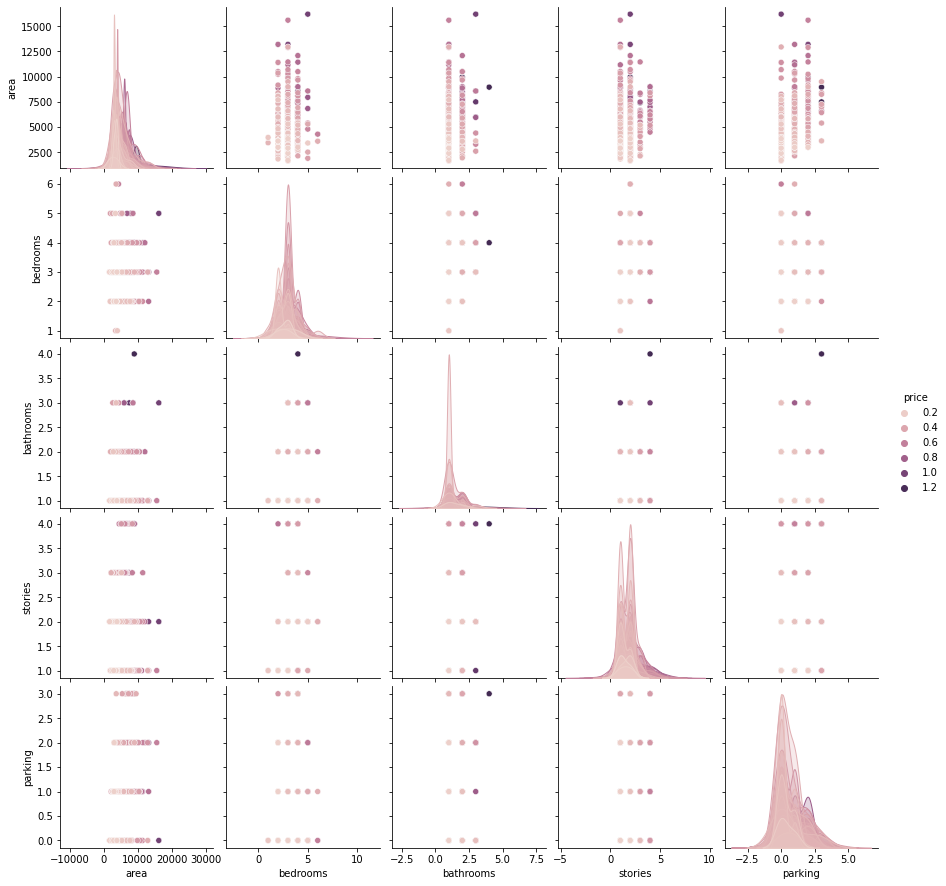

In [59]:
sns.pairplot(df, hue = 'price')

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


## Preprocessing (Dropping Nulls, Encoding object features)

In [61]:
df = df.dropna()

In [62]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [63]:
cat_feature = list(df.select_dtypes(include = ['object']).columns)
cat_feature

['mainroad',
 'guestroom',
 'basement',
 'hotwaterheating',
 'airconditioning',
 'prefarea',
 'furnishingstatus']

In [64]:
encoder = LabelEncoder()
for col in cat_feature:
    df[col] = encoder.fit_transform(df[col])
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0


## Splitting the data into Training and Test Sets

In [65]:
X = df.drop(['price'], axis=1)
y = df['price'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(381, 12) (164, 12) (381,) (164,)


In [66]:
X_train

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
454,4500,3,1,2,1,0,0,0,1,0,0,2
392,3990,3,1,2,1,0,0,0,0,0,0,1
231,4320,3,1,1,1,0,0,0,0,0,1,1
271,1905,5,1,2,0,0,1,0,0,0,0,1
250,3510,3,1,3,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
70,4000,3,2,2,1,0,1,0,1,0,1,1
277,10360,2,1,1,1,0,0,0,0,1,1,1
9,5750,3,2,4,1,1,0,0,1,1,1,2
359,3600,3,1,1,1,0,0,0,0,1,0,2


In [67]:
y_train

454    3143000
392    3500000
231    4690000
271    4340000
250    4515000
        ...   
70     6790000
277    4305000
9      9800000
359    3710000
192    5040000
Name: price, Length: 381, dtype: int64

## Using a simple Decision Tree regressor to predict the price of a house (without any validation) and finding the accuracy.

In [68]:
dtreregressor = DecisionTreeRegressor(max_depth=3)
dtreregressor.fit(X_train, y_train)
y_pred = dtreregressor.predict(X_test)

acc = r2_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.4737845219169856


## Performing 5-fold cross-validation to determine what the best max_depth would be for a single regression tree using the entire 'Xtrain' feature set and visualizing the results.

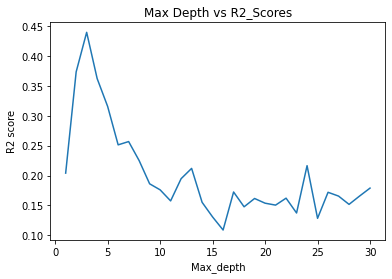


Best max_depth: 3


In [69]:
def best_max_depth_using_cross_validation_score(X, y):
    max_depth_range = range(1, 31)
    scores = []
    for max_depth in max_depth_range:
        dtreregressor = DecisionTreeRegressor(max_depth=max_depth)
        scores.append(cross_val_score(dtreregressor, X, y, scoring='r2', cv=5).mean())
    plt.plot(max_depth_range, scores)
    plt.title("Max Depth vs R2_Scores")
    plt.xlabel('Max_depth')
    plt.ylabel('R2 score')
    plt.show()  
    return max_depth_range[scores.index(max(scores))]

ans = best_max_depth_using_cross_validation_score(X_train, y_train)
print("\nBest max_depth:", ans)

## Applying bagging to create different training datasets and training on different dataset to obtain different decision trees.

In [70]:
def bagging(X, y, max_depth_b, n_estimators=10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    regressor_list = []
    pred_list = []
    r2_scores = []
    for i in range(n_estimators):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
        dtreregressor = DecisionTreeRegressor(max_depth = max_depth_b)
        dtreregressor.fit(X_train, y_train)
        y_pred = dtreregressor.predict(X_test)
        regressor_list.append(dtreregressor)
        pred_list.append(y_pred)
    
    return regressor_list, pred_list, r2_scores, y_test

In [71]:
regressor_list, pred_list, r2_scores, new_y_test = bagging(X_train, y_train, ans, n_estimators=10)

## Summarizing how each of the separate trees performed (both numerically and visually) using R-squared score as the metric.

### Numerical

In [72]:
for i in range(len(pred_list)):
        score = r2_score(new_y_test, pred_list[i])
        r2_scores.append(score)
        print(f"R2 Score for Tree Number {i+1} is",score)

R2 Score for Tree Number 1 is -0.4409599135472917
R2 Score for Tree Number 2 is -0.8815946486002628
R2 Score for Tree Number 3 is -0.7137623034551461
R2 Score for Tree Number 4 is -0.8507217473451243
R2 Score for Tree Number 5 is -0.4074423628589767
R2 Score for Tree Number 6 is -0.3123146298164772
R2 Score for Tree Number 7 is -0.49675605669483947
R2 Score for Tree Number 8 is -0.32874508340676245
R2 Score for Tree Number 9 is -0.9001044357088146
R2 Score for Tree Number 10 is 0.5638473631863805


### Visual

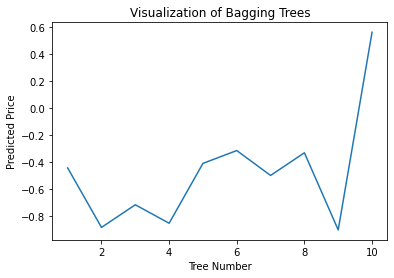

In [73]:
plt.plot([int(x) for x in range(1,11,1)], r2_scores)
plt.title("Visualization of Bagging Trees")
plt.xlabel('Tree Number')
plt.ylabel('Predicted Price')
plt.show()

## How they performed on average.

In [74]:
print("\nAverage R2 Score of all trees:", np.mean(r2_scores))


Average R2 Score of all trees: -0.47685538182473153


# Combining the trees into one prediction and evaluating it using R-squared score.

In [75]:
def combining_bagging_trees(regressor_list, pred_list, r2_scores):
    final_pred_list = []
    for i in range(len(pred_list)):
        final_pred_list.append(pred_list[i])
    final_pred_list = np.array(final_pred_list)
    final_pred_list = np.mean(final_pred_list, axis=0)
    final_pred_list = final_pred_list.reshape(-1,1)
    return final_pred_list

In [76]:
final_y_pred = combining_bagging_trees(regressor_list, pred_list, r2_scores)
print(final_y_pred)

[[4600296.91878888]
 [5222817.79422378]
 [4041559.8041043 ]
 [5444678.45371449]
 [4423084.78737466]
 [4835524.89907759]
 [4918980.3497762 ]
 [4727049.63344174]
 [5356426.97414196]
 [4433007.81650733]
 [3907501.14591586]
 [5729835.06170976]
 [5438486.11169242]
 [4346098.37950044]
 [4258029.38722581]
 [5129411.73087147]
 [4424744.20343126]
 [4787938.32558492]
 [5377932.63593625]
 [4888920.33131297]
 [4637692.65962999]
 [4645317.50573458]
 [4405419.39418965]
 [4242317.1793511 ]
 [4353624.22130179]
 [5164518.17570882]
 [5280047.27628875]
 [4073904.77369496]
 [4841557.49495506]
 [4591150.74645428]
 [5238539.31642142]
 [4336090.81314397]
 [5464852.4961869 ]
 [4260894.90430936]
 [4408375.41157041]
 [5033310.19492229]
 [4581204.9970902 ]
 [4505684.42546684]
 [5095185.73744022]
 [4546579.82117774]
 [4871155.51078431]
 [4522237.19419926]
 [5161044.73867319]
 [4104549.85447292]
 [5271609.34400744]
 [4957310.37270611]
 [4336261.95557697]
 [4342378.57155673]
 [4206539.36838779]
 [3950560.80681613]


In [77]:
print("\nFinal R2 Score of Combined Trees:", r2_score(new_y_test, final_y_pred))


Final R2 Score of Combined Trees: 0.039953870306094874


## When Max Depth is increased.

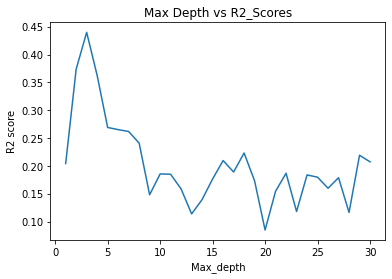


New Max Depth: 5


In [78]:
new_increased_depth = best_max_depth_using_cross_validation_score(X_train, y_train) + 2
print("\nNew Max Depth:", new_increased_depth)

In [79]:
inc_regressor_list, inc_pred_list, inc_r2_scores, inc_new_y_test = bagging(X_train, y_train, new_increased_depth, n_estimators=10)
for i in range(len(inc_pred_list)):
    score = r2_score(inc_new_y_test, inc_pred_list[i])
    inc_r2_scores.append(score)
    print(f"R2 Score for Tree Number {i+1} is",score)

R2 Score for Tree Number 1 is -0.632065356342745
R2 Score for Tree Number 2 is -1.2187734259717624
R2 Score for Tree Number 3 is -0.9114578984771982
R2 Score for Tree Number 4 is -1.5626380138801101
R2 Score for Tree Number 5 is -1.0686831171034812
R2 Score for Tree Number 6 is -0.5918703025365821
R2 Score for Tree Number 7 is -1.1789748285373167
R2 Score for Tree Number 8 is -0.5569670911628157
R2 Score for Tree Number 9 is -1.6611151453127415
R2 Score for Tree Number 10 is 0.4793354522614848


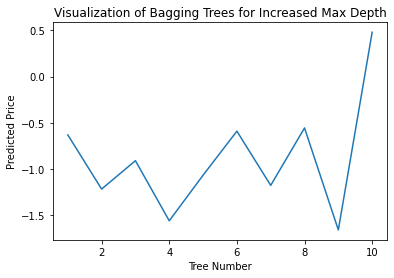

In [80]:
plt.plot([int(x) for x in range(1,11,1)], inc_r2_scores)
plt.title("Visualization of Bagging Trees for Increased Max Depth")
plt.xlabel('Tree Number')
plt.ylabel('Predicted Price')
plt.show()

In [81]:
inc_final_y_pred = combining_bagging_trees(inc_regressor_list, inc_pred_list, inc_r2_scores)
print("\nFinal R2 Score of Combined Trees for Increased Max Depth:", r2_score(inc_new_y_test, inc_final_y_pred))


Final R2 Score of Combined Trees for Increased Max Depth: -0.0020535901424156844


## When Max Depth is decreased

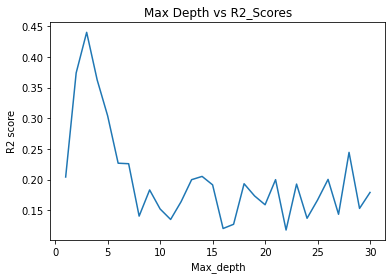


New Max Depth: 2


In [82]:
new_decreased_depth = best_max_depth_using_cross_validation_score(X_train, y_train) - 1
print("\nNew Max Depth:", new_decreased_depth)

In [83]:
dec_regressor_list, dec_pred_list, dec_r2_scores, dec_new_y_test = bagging(X_train, y_train, new_decreased_depth, n_estimators=10)
for i in range(len(dec_pred_list)):
    score = r2_score(dec_new_y_test, dec_pred_list[i])
    dec_r2_scores.append(score)
    print(f"R2 Score for Tree Number {i+1} is",score)

R2 Score for Tree Number 1 is -0.37025868026767395
R2 Score for Tree Number 2 is -0.6140859869726236
R2 Score for Tree Number 3 is -0.5005983357127577
R2 Score for Tree Number 4 is -0.6241971330968725
R2 Score for Tree Number 5 is -0.29385276842935015
R2 Score for Tree Number 6 is -0.2554487453906964
R2 Score for Tree Number 7 is -0.3437182516865618
R2 Score for Tree Number 8 is -0.3261933264124717
R2 Score for Tree Number 9 is -0.5265848835340929
R2 Score for Tree Number 10 is 0.48714654342561337


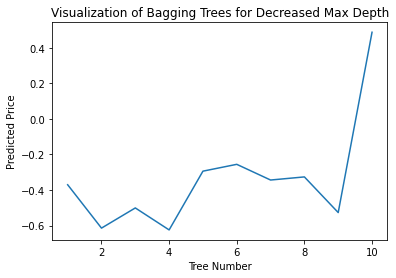

In [84]:
plt.plot([int(x) for x in range(1,11,1)], dec_r2_scores)
plt.title("Visualization of Bagging Trees for Decreased Max Depth")
plt.xlabel('Tree Number')
plt.ylabel('Predicted Price')
plt.show()

In [85]:
dec_final_y_pred = combining_bagging_trees(dec_regressor_list, dec_pred_list, dec_r2_scores)
print("\nFinal R2 Score of Combined Trees for Decreased Max Depth:", r2_score(dec_new_y_test, dec_final_y_pred))


Final R2 Score of Combined Trees for Decreased Max Depth: 0.05664300051789495


## Training random forest regressor, reporting mean squared error and mean absolute error.

In [86]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [87]:
random_forest_regressor = RandomForestRegressor(n_estimators=50)
random_forest_regressor.fit(X_train, y_train)
y_pred = random_forest_regressor.predict(X_test)

In [88]:
print(y_test)

239    4585000
113    6083000
325    4007500
66     6930000
479    2940000
        ...   
477    2940000
505    2653000
347    3836000
224    4760000
38     7962500
Name: price, Length: 164, dtype: int64


In [89]:
y_pred = pd.Series(y_pred)
print(y_pred)

0      4400340.0
1      5244960.0
2      4679920.0
3      5439840.0
4      3005520.0
         ...    
159    3177020.0
160    3366860.0
161    2890860.0
162    5156340.0
163    7357700.0
Length: 164, dtype: float64


In [90]:
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 1276332056747.2378
Mean Absolute Error: 829701.5955284552
R2 Score: 0.6320510188005333


## Training Adaboost regressor and reporting mean squared error and mean absolute error.

In [91]:
ada_boost_regressor = AdaBoostRegressor(n_estimators = 50)
ada_boost_regressor.fit(X_train, y_train)
y_pred = ada_boost_regressor.predict(X_test)

In [92]:
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 1629098192593.5369
Mean Absolute Error: 974926.9926690547
R2 Score: 0.5303533927006947


# Question 2

## Installing xgboost and lightgbm libraries.

In [93]:
!pip install xgboost
!pip install lightgbm

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

In [95]:
df2 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Breast_cancer_data.csv")

## Visualizing the given data

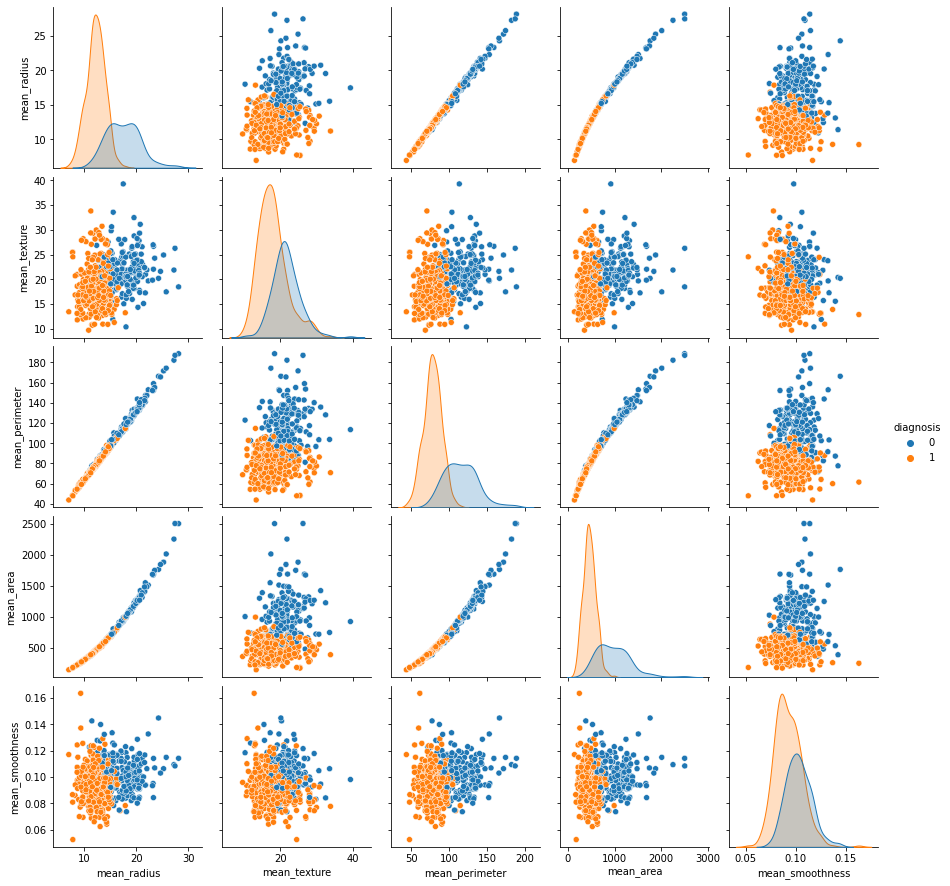

In [96]:
sns.pairplot(df2, hue = 'diagnosis')

In [97]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.8 KB


## Preprocessing the data (including dropping nulls)

In [98]:
df2 = df2.dropna()

## Splitting the dataset into training and testing sets

In [99]:
X2 = df2.drop(['diagnosis'], axis=1)
y2 = df2['diagnosis']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=0)

## Using a simple Decision Tree classifier to predict the outcome (without any validation) and reporting the accuracy

In [100]:
def DecisionTreeClassifier_acc(X_train, X_test, y_train, y_test):
    dtclassifier = DecisionTreeClassifier(random_state = 0)
    dtclassifier.fit(X_train, y_train)
    y_pred = dtclassifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc

In [101]:
print("Accuracy of Decision Tree Classifier is:", DecisionTreeClassifier_acc(X_train2, X_test2, y_train2, y_test2))

Accuracy of Decision Tree Classifier is: 0.9239766081871345


## Performing 5-fold cross-validation to determine what the best max_depth would be for a single regression tree using the entire 'Xtrain' feature set.

In [102]:
def best_max_depth_using_cross_validation_score(X, y):
    max_depth_range = range(1, 101)
    scores = []
    for max_depth in max_depth_range:
        dtreregressor = DecisionTreeRegressor(max_depth=max_depth)
        scores.append(cross_val_score(dtreregressor, X, y, scoring='r2', cv=5).mean())
    plt.plot(max_depth_range, scores)
    plt.title("Max Depth vs. Cross Validation Scores")
    plt.xlabel('Max_depth')
    plt.ylabel('R2 score')
    plt.show()  
    return max_depth_range[scores.index(max(scores))]

## Visualizing and summarizing the results

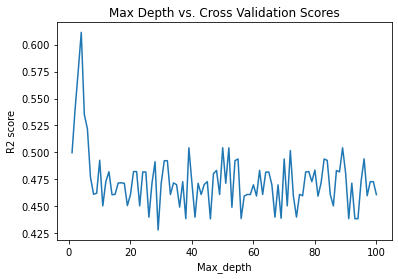

Best max_depth: 4


In [103]:
ans = best_max_depth_using_cross_validation_score(X_train2, y_train2)
print("Best max_depth:", ans)

## Implementing XGBoost in which subsample=0.7 and max_depth=4.

In [104]:
import xgboost as xgb
def xgboost(X_train, X_test, y_train, y_test):
    xg_reg = xgb.XGBClassifier(objective="binary:logistic", subsample =0.7, max_depth=4, n_estimators=10)
    xg_reg.fit(X_train, y_train)
    y_pred = xg_reg.predict(X_test)
    # print(y_test)
    # print(y_pred)
    acc = accuracy_score(y_test, y_pred)
    return acc

In [105]:
xgboost_accuracy_train = xgboost(X_test2, X_train2, y_test2, y_train2)
xgboost_accuracy_test = xgboost(X_train2, X_test2, y_train2, y_test2)
print("The accuracy obtained on the training set is: ", xgboost_accuracy_train)
print("The accuracy obtained on the testing set is: ", xgboost_accuracy_test)

The accuracy obtained on the training set is:  0.8919597989949749
The accuracy obtained on the testing set is:  0.935672514619883


## Implementing LightGBM with max_depth value as 3 and choosing different values for num_leaves.

In [106]:
import lightgbm as lgb
def lightBGM(X_train, X_test, y_train, y_test, max_depth_given, num_leaves_given):
    lgbm = lgb.LGBMClassifier(max_depth=max_depth_given, num_leaves=num_leaves_given)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc

In [107]:
for i in range(2, 15):
    print("LightGBM with max_depth=3 and num_leaves=", i, ":", lightBGM(X_train2, X_test2, y_train2, y_test2, 3, i))

LightGBM with max_depth=3 and num_leaves= 2 : 0.9181286549707602
LightGBM with max_depth=3 and num_leaves= 3 : 0.9239766081871345
LightGBM with max_depth=3 and num_leaves= 4 : 0.9239766081871345
LightGBM with max_depth=3 and num_leaves= 5 : 0.9239766081871345
LightGBM with max_depth=3 and num_leaves= 6 : 0.9181286549707602
LightGBM with max_depth=3 and num_leaves= 7 : 0.9181286549707602
LightGBM with max_depth=3 and num_leaves= 8 : 0.9122807017543859
LightGBM with max_depth=3 and num_leaves= 9 : 0.9122807017543859
LightGBM with max_depth=3 and num_leaves= 10 : 0.9122807017543859
LightGBM with max_depth=3 and num_leaves= 11 : 0.9122807017543859
LightGBM with max_depth=3 and num_leaves= 12 : 0.9122807017543859
LightGBM with max_depth=3 and num_leaves= 13 : 0.9122807017543859
LightGBM with max_depth=3 and num_leaves= 14 : 0.9122807017543859


## Analysing the relation between max_depth and num_leaves, and checking for the value at which the model starts overfitting.

In [108]:
val = 8
for i in range(2,15):
    print(f"LightGBM with max_depth = {i} and num_leaves = {val} : {lightBGM(X_train2, X_test2, y_train2, y_test2, i, val)}")

LightGBM with max_depth = 2 and num_leaves = 8 : 0.9239766081871345
LightGBM with max_depth = 3 and num_leaves = 8 : 0.9122807017543859
LightGBM with max_depth = 4 and num_leaves = 8 : 0.9122807017543859
LightGBM with max_depth = 5 and num_leaves = 8 : 0.9181286549707602
LightGBM with max_depth = 6 and num_leaves = 8 : 0.9298245614035088
LightGBM with max_depth = 7 and num_leaves = 8 : 0.9298245614035088
LightGBM with max_depth = 8 and num_leaves = 8 : 0.9298245614035088
LightGBM with max_depth = 9 and num_leaves = 8 : 0.9298245614035088
LightGBM with max_depth = 10 and num_leaves = 8 : 0.9298245614035088
LightGBM with max_depth = 11 and num_leaves = 8 : 0.9298245614035088
LightGBM with max_depth = 12 and num_leaves = 8 : 0.9298245614035088
LightGBM with max_depth = 13 and num_leaves = 8 : 0.9298245614035088
LightGBM with max_depth = 14 and num_leaves = 8 : 0.9298245614035088


## Reporting which parameters can be used for better accuracy and also which parameter can be used for avoiding overfitting.

In [109]:
for i in range(1,20,1):
    lgbm_new  = lgb.LGBMClassifier(max_depth=6, num_leaves=8, min_data_in_leaf = i)
    lgbm_new.fit(X_train2, y_train2)
    y_pred = lgbm_new.predict(X_test2)
    acc = accuracy_score(y_test2, y_pred)
    print("LightGBM with max_depth=6, num_leaves=8, min_data_in_leaf=", i, ":", acc)

LightGBM with max_depth=6, num_leaves=8, min_data_in_leaf= 1 : 0.9181286549707602
LightGBM with max_depth=6, num_leaves=8, min_data_in_leaf= 2 : 0.9181286549707602
LightGBM with max_depth=6, num_leaves=8, min_data_in_leaf= 3 : 0.9239766081871345
LightGBM with max_depth=6, num_leaves=8, min_data_in_leaf= 4 : 0.9239766081871345
LightGBM with max_depth=6, num_leaves=8, min_data_in_leaf= 5 : 0.9122807017543859
LightGBM with max_depth=6, num_leaves=8, min_data_in_leaf= 6 : 0.9181286549707602
LightGBM with max_depth=6, num_leaves=8, min_data_in_leaf= 7 : 0.9181286549707602
LightGBM with max_depth=6, num_leaves=8, min_data_in_leaf= 8 : 0.9181286549707602
LightGBM with max_depth=6, num_leaves=8, min_data_in_leaf= 9 : 0.9239766081871345
LightGBM with max_depth=6, num_leaves=8, min_data_in_leaf= 10 : 0.9298245614035088
LightGBM with max_depth=6, num_leaves=8, min_data_in_leaf= 11 : 0.9239766081871345
LightGBM with max_depth=6, num_leaves=8, min_data_in_leaf= 12 : 0.9298245614035088
LightGBM with